In [1]:
import sys
sys.path.append(r'C:\Users\Administrator\finstral-1') # Replace with your actual path


# Questrade Market Data Management System Notebook

This notebook demonstrates how to use the market data management system for Questrade API. The system fetches, stores, and analyzes candlestick data from Questrade's API using SQLite or PostgreSQL databases, with support for Parquet file conversion.

## 1. Setup and Configuration


In [2]:
import sys
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sqlite3
import time

# Configure the data management system
import src.local_symbols as local_symbols
import src.qt_api.qt_api as qt
import src.local_candles as local_candles

# Set up configuration variables
# Change these variables in src/local_candles.py 
DB_SYSTEM = 'sqlite'  # Could be 'postgres' for production 
DEBUG = True

# Set plot style
plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## 2. Database Initialization

Let's first initialize our database and make sure the required tables exist.


In [3]:
# First, ensure our data directory exists
local_candles.ensure_data_directory()

# Initialize the database
local_candles.initialize_db()

# Apply database optimizations (indexes)
local_candles.optimize_database()

# Print database location
data_dir = Path('../data')
db_path = data_dir / 'candles.db'
print(f"Database initialized at: {db_path}")

# Check database tables
with local_candles.get_db_connection() as conn:
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    print("\nDatabase tables:")
    for table in tables:
        print(f"- {table[0]}")
DEBUG = False

✓ Data directory ensured at: C:\Users\Administrator\finstral-1\data
➡ Initializing database at: C:\Users\Administrator\finstral-1\data\candles.db
✓ Database tables created successfully
✓ Database optimization complete.
Database initialized at: ..\data\candles.db

Database tables:
- symbols
- candles
- sqlite_sequence


## 3. Retrieving and Storing Candle Data

Now, let's explore how to fetch and store candle data for specific symbols.


In [4]:
# Define a symbol we want to work with
test_symbol = "AAPL"  # Apple Inc.


In [5]:
# First, let's see how to fetch candle data directly from Questrade API
print(f"Fetching candle data for {test_symbol} from Questrade API...")
candle_df = local_candles.get_candle_df(test_symbol, days_back=7, interval="OneMinute")
print(f"Retrieved {len(candle_df)} candles")

# Display a sample of the data
display(candle_df.head())

Fetching candle data for AAPL from Questrade API...


Retrieved 3920 candles


,start,end,low,high,open,close,volume,VWAP,symbol,interval
0,2025-03-31T04:38:00.000000-04:00,2025-03-31T04:39:00.000000-04:00,215.87,215.88,215.87,215.88,211,215.808096,AAPL,OneMinute
1,2025-03-31T04:40:00.000000-04:00,2025-03-31T04:41:00.000000-04:00,215.90,216.12,215.90,216.12,396,216.003899,AAPL,OneMinute
2,2025-03-31T04:43:00.000000-04:00,2025-03-31T04:44:00.000000-04:00,215.00,215.89,215.89,215.00,6306,215.571676,AAPL,OneMinute
3,2025-03-31T04:45:00.000000-04:00,2025-03-31T04:46:00.000000-04:00,215.32,215.49,215.32,215.49,793,215.551433,AAPL,OneMinute
4,2025-03-31T04:46:00.000000-04:00,2025-03-31T04:47:00.000000-04:00,215.28,215.61,215.28,215.61,730,215.548003,AAPL,OneMinute


In [6]:
# Now, let's update the database with this data
print(f"\nUpdating database with candle data for {test_symbol}...")
local_candles.update_candles_for_symbol(test_symbol, interval="OneMinute")
print("Update complete")


Updating database with candle data for AAPL...
⚠ No new candle updates for symbol AAPL
Update complete


In [7]:
# Retrieve the data from the database to verify it was stored
candles_from_db = local_candles.get_candle_from_db(test_symbol, interval="OneMinute")
print(f"Retrieved {len(candles_from_db)} candles from database")

# Display a sample of the data from the database
display(candles_from_db.head())

Retrieved 44372 candles from database


,id,symbol,interval,start,end,open,high,low,close,volume,VWAP
0,10274351,AAPL,OneMinute,2025-01-06T04:24:00.000000-05:00,2025-01-06T04:25:00.000000-05:00,245.04,245.04,245.04,245.04,100,245.063841
1,10274352,AAPL,OneMinute,2025-01-06T04:25:00.000000-05:00,2025-01-06T04:26:00.000000-05:00,245.03,245.12,245.03,245.12,630,245.060742
2,10274353,AAPL,OneMinute,2025-01-06T04:26:00.000000-05:00,2025-01-06T04:27:00.000000-05:00,245.08,245.08,245.07,245.07,200,245.056189
3,10274354,AAPL,OneMinute,2025-01-06T04:28:00.000000-05:00,2025-01-06T04:29:00.000000-05:00,245.02,245.07,245.02,245.07,1250,245.048035
4,10274355,AAPL,OneMinute,2025-01-06T04:29:00.000000-05:00,2025-01-06T04:30:00.000000-05:00,245.02,245.03,244.94,244.94,1521,245.036857


## 4. Working with Time Series Data

Let's explore how to work with the time series data we've collected.


Retrieved 3200 candles for period 2025-04-01 to 2025-04-06


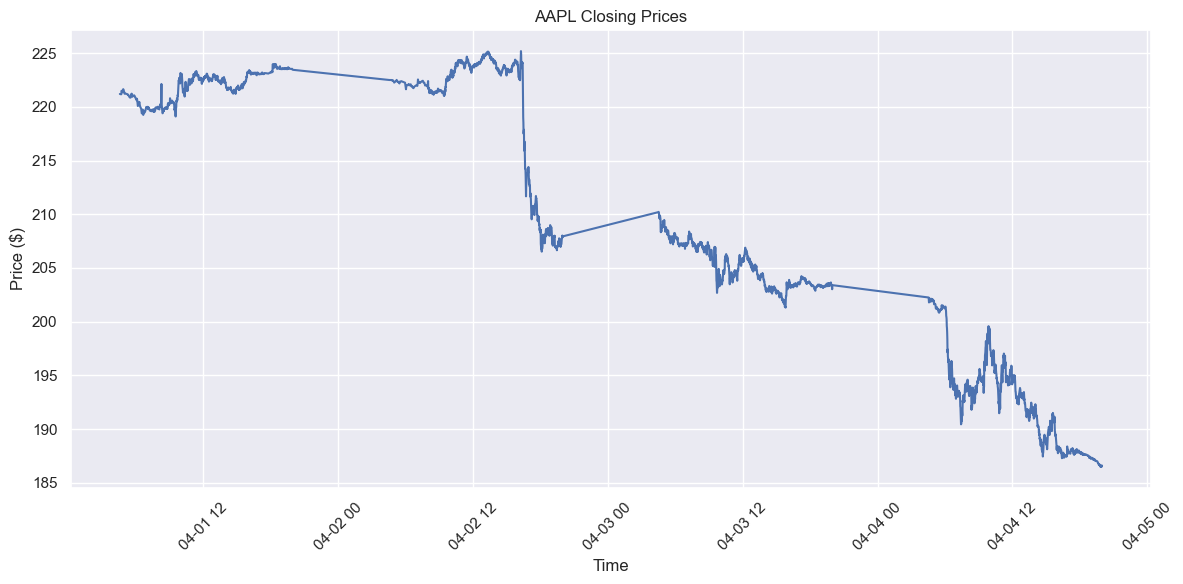

Latest price for AAPL: $186.60


In [8]:
# Get data for a specific time period
start_date = (datetime.datetime.now() - datetime.timedelta(days=5)).strftime("%Y-%m-%d")
end_date = datetime.datetime.now().strftime("%Y-%m-%d")

period_candles = local_candles.get_candles_for_period(
    test_symbol, 
    start_date, 
    end_date, 
    interval="OneMinute"
)

print(f"Retrieved {len(period_candles)} candles for period {start_date} to {end_date}")

# Convert the 'start' column to datetime for proper plotting
period_candles['start'] = pd.to_datetime(period_candles['start'])

# Create a simple plot of closing prices
plt.figure(figsize=(12, 6))
plt.plot(period_candles['start'], period_candles['close'])
plt.title(f"{test_symbol} Closing Prices")
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Get the latest price
latest_price = local_candles.get_latest_price(test_symbol)
print(f"Latest price for {test_symbol}: ${latest_price:.2f}")


## 5. Working with Multiple Symbols

Let's update multiple symbols and analyze a small portfolio.


In [9]:
# Define a list of symbols for our example portfolio
portfolio_symbols = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]

# Let's manually update our symbols one by one
for symbol in portfolio_symbols:
    try:
        local_candles.update_candles_for_symbol(symbol, interval="OneMinute")
        print(f"Updated {symbol} successfully")
    except Exception as e:
        print(f"Error updating {symbol}: {e}")

⚠ No new candle updates for symbol AAPL
Updated AAPL successfully
⚠ No new candle updates for symbol MSFT
Updated MSFT successfully
⚠ No new candle updates for symbol GOOGL
Updated GOOGL successfully
⚠ No new candle updates for symbol AMZN
Updated AMZN successfully
⚠ No new candle updates for symbol TSLA
Updated TSLA successfully


In [10]:
# Alternatively, we could use update_all_symbols() to update all symbols in the database
UPDATE_ALL_SYMBOLS = True # Change to True to update all symbols
if UPDATE_ALL_SYMBOLS:
    print("Updating all symbols in database...")
    local_candles.update_all_symbols(backup_db=True)


Updating all symbols in database...
➡ Initializing database at: C:\Users\Administrator\finstral-1\data\candles.db
✓ Database tables created successfully
✓ Database optimization complete.
[░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 0.0% - Processing: BRK.B⚠ No new candle updates for symbol BRK.B
[░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 0.2% - Processing: LLY⚠ No new candle updates for symbol LLY
[░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 0.3% - Processing: XOM⚠ No new candle updates for symbol XOM
[░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 0.5% - Processing: MA⚠ No new candle updates for symbol MA
[░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 0.6% - Processing: ABBV⚠ No new candle updates for symbol ABBV
[░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 0.8% - Processing: BAC⚠ No new candle updates for symbol BAC
[░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 1.0% - Processing: PM⚠ No new candle updates for symbol PM
[░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 1.1% - Processing: WFC⚠ No new candle updates for symbol WFC
[░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 1.3% - Processing: ABT⚠ No

,Symbol,Latest Price
0,AAPL,186.60
1,MSFT,359.75
2,GOOGL,144.75
3,AMZN,170.20
4,TSLA,235.23


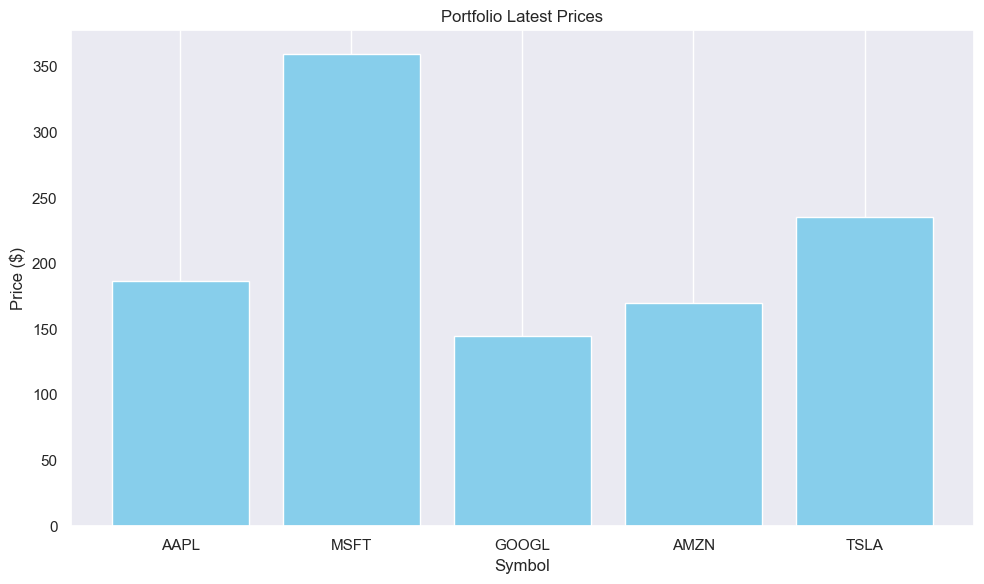

In [11]:



# Now let's fetch the latest prices for our portfolio
portfolio_prices = {}
for symbol in portfolio_symbols:
    price = local_candles.get_latest_price(symbol)
    portfolio_prices[symbol] = price

# Create a DataFrame to display the portfolio
portfolio_df = pd.DataFrame({
    'Symbol': portfolio_prices.keys(),
    'Latest Price': portfolio_prices.values()
})

# Display the portfolio
display(portfolio_df)

# Create a bar chart of the portfolio prices
plt.figure(figsize=(10, 6))
plt.bar(portfolio_df['Symbol'], portfolio_df['Latest Price'], color='skyblue')
plt.title('Portfolio Latest Prices')
plt.xlabel('Symbol')
plt.ylabel('Price ($)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## 6. Converting Database to Parquet Format

Parquet is a columnar storage format that provides efficient data compression and encoding schemes, making it good for time series data.



In [12]:
run_parquet = False # Change to True to run the conversion
if run_parquet:
    # Convert the database to Parquet format
    print("Converting database to Parquet format...")
    local_candles.db_to_parquet()

# Try to load the Parquet file
try:
    parquet_df = local_candles.load_parquet()
    print(f"Loaded Parquet file with {len(parquet_df)} records")
    
    # Display the first few rows
    display(parquet_df.head())
    
except FileNotFoundError as e:
    print(f"Error: {e}")

[WindowsPath('C:/Users/Administrator/finstral-1/data/parquet/20250406_AG_combined.parquet')]
📂 Loading most recent parquet file: 20250406_AG_combined.parquet
Loaded Parquet file with 15765758 records


interval                  end    open    high     low   close  volume        VWAP     industrySector
item_id timestamp                                                                                                                 
BRK.B   2025-01-06 06:15:00  OneMinute  2025-01-06 06:16:00  456.10  456.20  456.10  456.20     258  455.882852  FinancialServices
        2025-01-06 06:21:00  OneMinute  2025-01-06 06:22:00  456.35  456.35  456.35  456.35     100  455.961142  FinancialServices
        2025-01-06 07:00:00  OneMinute  2025-01-06 07:01:00  456.54  456.54  456.07  456.07     300  456.179291  FinancialServices
        2025-01-06 07:59:00  OneMinute  2025-01-06 08:00:00  456.30  456.30  456.30  456.30     346  456.208096  FinancialServices
        2025-01-06 08:00:00  OneMinute  2025-01-06 08:01:00  456.71  456.71  456.31  456.31    1484  456.240498  FinancialServices

## 7. Visualizing Candle Data

Let's use our custom function to plot OHLC data for a specific symbol.



Plotting AAPL from Parquet data...


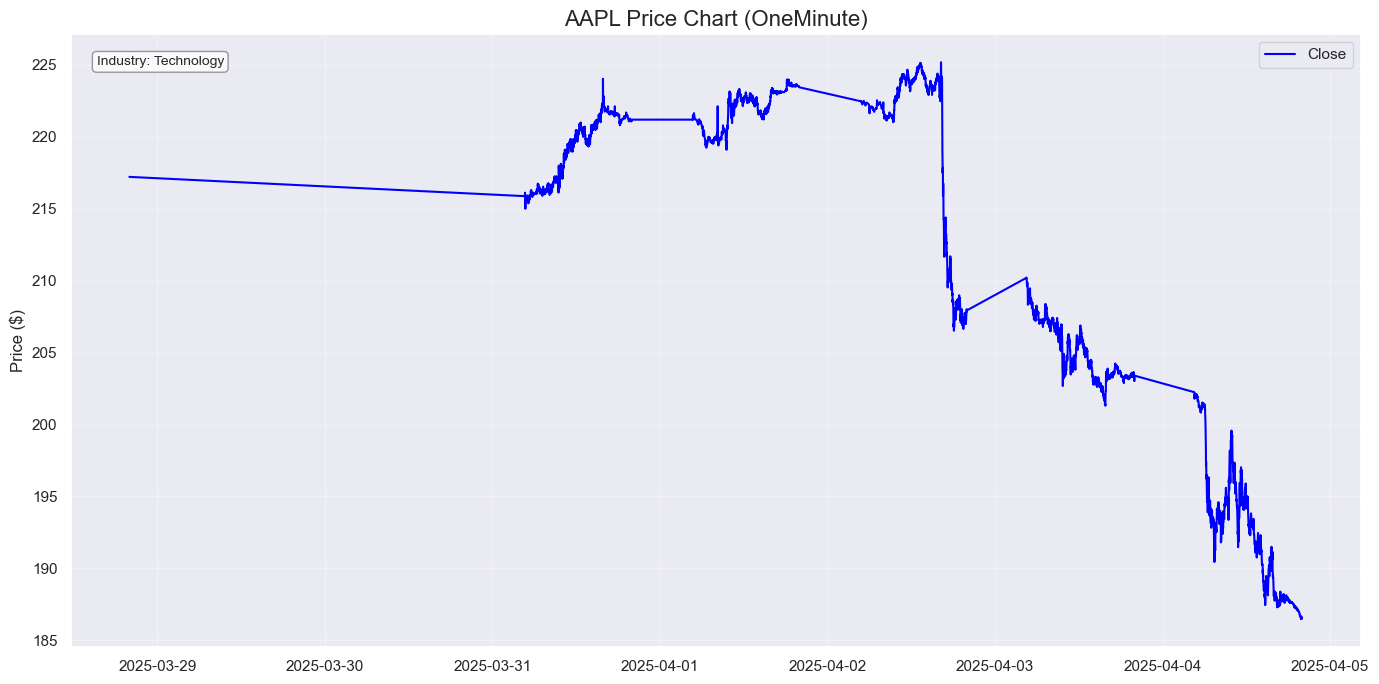

In [13]:
# Let's use our plotting function to visualize a stock
try:
    symbol_to_plot = "AAPL"
    
    # Check if the symbol exists in the parquet data
    if symbol_to_plot in parquet_df.index.get_level_values('item_id'):  # symbol is in the item_id index
        print(f"Plotting {symbol_to_plot} from Parquet data...")
        local_candles.parquet_plot_ohlc(parquet_df, symbol_to_plot, interval='OneMinute', n_days=7)
    else:
        print(f"Symbol '{symbol_to_plot}' not found in Parquet data, trying database...")
        
        # Option 2: Plot from database
        candles = local_candles.get_candle_from_db(symbol_to_plot, interval="OneMinute")
        
        if not candles.empty:
            # Convert to the format expected by the plotting function
            # Use utc=True to avoid FutureWarning about mixed time zones
            candles['start'] = pd.to_datetime(candles['start'], utc=True)
            # Set the multi-index with item_id (symbol) and timestamp (start)
            candles.rename(columns={'symbol': 'item_id'}, inplace=True)
            candles.set_index(['item_id', 'start'], inplace=True)
            candles.index.names = ['item_id', 'timestamp']
            
            # Plot the data
            local_candles.parquet_plot_ohlc(candles, symbol_to_plot, interval='OneMinute', n_days=1)
        else:
            print(f"No data found for symbol '{symbol_to_plot}' with interval 'OneMinute'")
        
except Exception as e:
    print(f"Error plotting data: {e}")


## 8. Preparing Data for AutoGluon (Time Series Forecasting)

The system includes functionality to prepare data for time series forecasting with AutoGluon.


In [14]:
# This would update all symbols and prepare a combined file for AutoGluon
# Note: This can take a long time if you have many symbols
print("To prepare data for AutoGluon, you would run:")
print("ag_data = local_candles.prepare_parquet_autogluon(update_db=True)")
print("\nThis function:")
print("1. Updates candle data for all symbols")
print("2. Formats the data for time series forecasting")
print("3. Saves as a Parquet file with timestamp")
print("4. Creates a backup of the database")

# Instead of running the full process, let's demonstrate with a small subset
print("\nDemonstrating with a small subset (no updates)...")

# You could run this once a day to update the candle database and get a fresh parquet file
PREPARE_AUTOGLUON = False # Change to True to run the conversion
if PREPARE_AUTOGLUON:
    local_candles.prepare_parquet_autogluon(update_db=False) # Set update_db to True if needed


To prepare data for AutoGluon, you would run:
ag_data = local_candles.prepare_parquet_autogluon(update_db=True)

This function:
1. Updates candle data for all symbols
2. Formats the data for time series forecasting
3. Saves as a Parquet file with timestamp
4. Creates a backup of the database

Demonstrating with a small subset (no updates)...


## 9. Database Maintenance and Backup

In [15]:
# Create a backup of the database
print("Creating database backup...")
local_candles.backup_database()

# Verify the backup directory
backup_dir = Path('../data/backups')
if backup_dir.exists():
    backups = list(backup_dir.glob("*.db"))
    print(f"Found {len(backups)} database backups:")
    for backup in backups:
        backup_size = backup.stat().st_size / (1024 * 1024)  # Convert to MB
        print(f"- {backup.name} ({backup_size:.2f} MB)")
else:
    print("No backup directory found")

Creating database backup...
✓ Database backed up to C:\Users\Administrator\finstral-1\data\backups\candles_backup_20250406.db
Found 1 database backups:
- candles_backup_20250406.db (4207.76 MB)


## 10. System Performance Analysis

Let's analyze how the system is performing in terms of data storage efficiency.


In [16]:
# Check database size
db_size_bytes = db_path.stat().st_size
db_size_mb = db_size_bytes / (1024 * 1024)
print(f"Database size: {db_size_mb:.2f} MB")

# Count the number of candles in the database
with local_candles.get_db_connection() as conn:
    cursor = conn.cursor()
    cursor.execute("SELECT COUNT(*) FROM candles")
    candle_count = cursor.fetchone()[0]
    
    cursor.execute("SELECT COUNT(DISTINCT symbol) FROM candles")
    symbol_count = cursor.fetchone()[0]
    
    cursor.execute("SELECT symbol, COUNT(*) as candle_count FROM candles GROUP BY symbol ORDER BY candle_count DESC LIMIT 10")
    top_symbols = cursor.fetchall()

print(f"Total candles in database: {candle_count:,}")
print(f"Number of unique symbols: {symbol_count}")
print(f"Average candles per symbol: {candle_count/symbol_count if symbol_count else 0:,.0f}")

# Print top symbols by candle count
print("\nTop symbols by candle count:")
for symbol, count in top_symbols:
    print(f"- {symbol}: {count:,} candles")

# Calculate efficiency metrics
bytes_per_candle = db_size_bytes / candle_count if candle_count else 0
print(f"\nStorage efficiency: {bytes_per_candle:.2f} bytes per candle")

# Check database growth potential
estimated_daily_candles_per_symbol = 390  # ~6.5 hours × 60 minutes for US market
estimated_daily_growth = estimated_daily_candles_per_symbol * symbol_count * bytes_per_candle / (1024 * 1024)
print(f"Estimated daily database growth: {estimated_daily_growth:.2f} MB")
print(f"Estimated annual database growth: {estimated_daily_growth * 252:.2f} MB (252 trading days)")


Database size: 4207.76 MB


Total candles in database: 15,765,758
Number of unique symbols: 618
Average candles per symbol: 25,511

Top symbols by candle count:
- NVDA: 57,246 candles
- TSLL: 56,765 candles
- SOXL: 55,976 candles
- TSLA: 55,519 candles
- PLTR: 55,141 candles
- TQQQ: 53,644 candles
- SQQQ: 53,576 candles
- MSTU: 53,380 candles
- ETHU: 52,255 candles
- IBIT: 51,184 candles

Storage efficiency: 279.86 bytes per candle
Estimated daily database growth: 64.33 MB
Estimated annual database growth: 16210.24 MB (252 trading days)


## 11. Conclusion

This notebook has demonstrated the key functionality of the Questrade market data management system. The system provides:

1. Database initialization and optimization
2. Efficient storage of candle data from Questrade API
3. Flexible query capabilities for time series analysis
4. Support for both SQL and Parquet storage formats
5. Visualization tools for market data
6. Data preparation for advanced time series forecasting

The SQL-based approach offers several advantages:
- Efficient storage with indexes for fast queries
- Support for complex time-based filtering
- Easy backup and maintenance
- Integration with both SQLite (for development) and PostgreSQL (for production)

With this system, you can build a robust financial data pipeline for algorithmic trading, portfolio analysis, or market research applications.